In [46]:
import numpy as np
import secrets
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import style
import itertools
from scipy.optimize import curve_fit

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import torch.nn.functional as F

100%|██████████| 150/150 [02:22<00:00,  1.06it/s]


Total model parameters = 2945


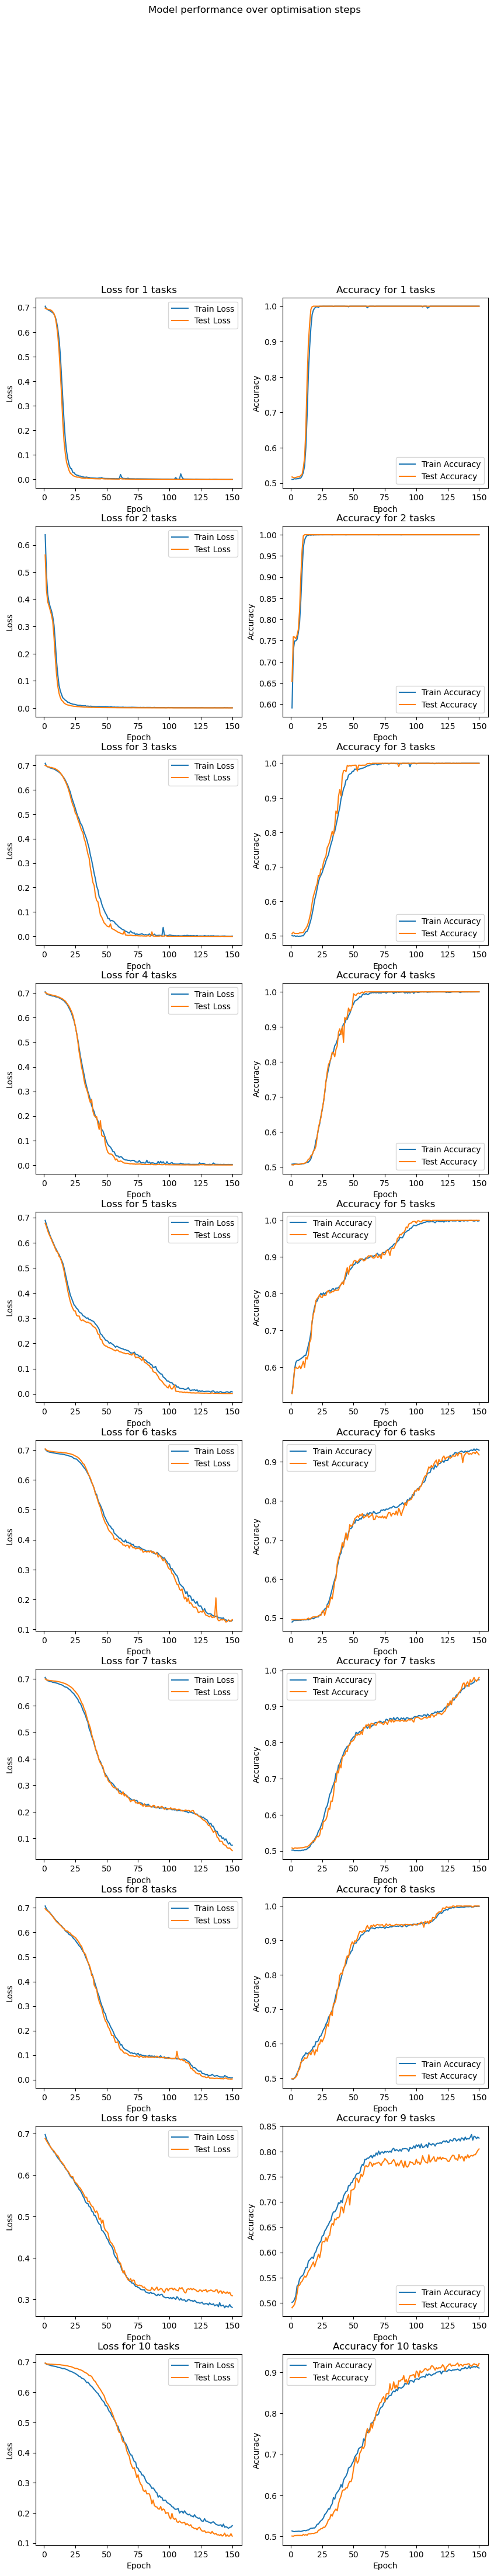

In [20]:
# n_tasks_list. variation of the number of tasks

# Parameters
#n_tasks = 10 # number of tasks created
n_tasks_list = np.arange(1, 11, 1)
len_taskcode = 8 # length of the code defining the task. This will go at the beginning of each entry
num_checks = 5  # Length of the associated integer list for each task. Must be less than len_message
len_message = 12  # Maximum integer value in the associated integer list
num_samples = 10000 # number of samples created in the dataset
samples_per_task = 1 # Kept at 1 for as long as I do not actually want to check the task performance
# Define hyperparameters
input_size = len_taskcode + len_message
output_size = 1
learning_rate = 0.005
batch_size = 32
num_epochs = 150
test_frac = 0.2
num_layers = 4
hidden_size = 32

def generate_random_binary_string(length):
    binary_string = ''.join(secrets.choice(['0', '1']) for _ in range(length))
    return binary_string

def generate_dict(n_tasks, len_taskcode, num_checks, len_message):
    unique_strings = set()
    tasks_dict = {}

    while len(unique_strings) < n_tasks:
        binary_string = generate_random_binary_string(len_taskcode)

        if binary_string not in unique_strings:
            unique_strings.add(binary_string)

            integer_list = [secrets.randbelow(len_message) for _ in range(num_checks)]
            tasks_dict[binary_string] = integer_list

    return tasks_dict

def generate_dataset(tasks_dict, num_samples):
  data = np.zeros((num_samples, len_taskcode + len_message))
  value = np.zeros(num_samples)
  for i in range(num_samples):
    rand_task = np.random.choice(list(tasks_dict))
    rand_checkbits = tasks_dict[rand_task]
    message = generate_random_binary_string(len_message)
    parity_bit = 0
    for j in rand_checkbits:
      parity_bit += int(message[j])
    parity = parity_bit % 2
    data[i] = np.concatenate((np.array(list(rand_task)), np.array(list(message))))
    value[i] = parity
  return [data, value]

# Define a NN class WITH BATCH NORMALISATION
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, output_size, num_layers, hidden_size):
        super(NeuralNetwork, self).__init__()

        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(input_size, hidden_size))  # Additional linear layer
        
        for _ in range(num_layers - 2):
            self.layers.append(nn.Linear(hidden_size, hidden_size))
            self.layers.append(nn.BatchNorm1d(hidden_size))  # Add BatchNorm1d layer
        
        self.layers.append(nn.Linear(hidden_size, output_size))
    
    def forward(self, x):
        for i, layer in enumerate(self.layers[:-1]):
            if i == 0:  # Apply ReLU activation only after the additional linear layer
                x = F.relu(layer(x))
            else:
                x = layer(x)
                if i % 2 == 0:
                    x = F.relu(x)  # Apply ReLU activation after each linear layer
        x = self.layers[-1](x)
        return x

# Define a custom dataset
class CustomDataset(Dataset):
    def __init__(self, dataframe):
        self.data = dataframe.iloc[:, :-1].values
        self.target = dataframe.iloc[:, -1].values
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        x = torch.from_numpy(self.data[idx]).float()
        y = torch.tensor(self.target[idx]).float()
        return x, y
    
#plt.close()
fig, axs = plt.subplots(len(n_tasks_list), 2, figsize=(10, len(n_tasks_list)*5))
for index, n_tasks in enumerate(n_tasks_list):
    #print(f"index = ", index)
    #print(f"n_tasks = ", n_tasks)
    
    tasks_dict = generate_dict(n_tasks, len_taskcode, num_checks, len_message)
    #print("Early: tasks_dict = ", tasks_dict.items())

    [data, value] = generate_dataset(tasks_dict, num_samples)

    # Create a dataframe for training
    df = pd.DataFrame(np.concatenate((data, value.reshape(-1, 1)), axis=1), columns=[f'feature_{i}' for i in range(len_taskcode + len_message)] + ['target'])

    # Split the data into training and test sets
    #train_df, test_df = train_test_split(df, test_size=test_frac, random_state=42)
    train_df, test_df = train_test_split(df, test_size=test_frac, random_state=42)

    # Create instances of the neural network
    model = NeuralNetwork(input_size, output_size, num_layers, hidden_size)

    # Define loss function and optimizer (same as before)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)

    # Create DataLoaders for the training and test data
    train_dataset = CustomDataset(train_df)
    test_dataset = CustomDataset(test_df)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    train_loss_list = np.empty(num_epochs)
    test_loss_list = np.empty(num_epochs)

    train_accuracy_list = np.empty(num_epochs)
    test_accuracy_list = np.empty(num_epochs)

    accuracy_array = np.zeros((n_tasks, num_epochs)) # such that each row is the accuracy for that specific task over all epochs

    # Train the model
    for epoch in tqdm(range(num_epochs)):
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        model.train()

        for inputs, labels in train_loader:
            # Forward pass
            outputs = model(inputs)

            # Compute loss
            loss = criterion(outputs, labels.unsqueeze(1))

            # Compute predictions
            predictions = (outputs >= 0.5).squeeze().long()

            # Compute accuracy
            train_correct += (predictions == labels).sum().item()
            train_total += labels.size(0)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)

        # Calculate average train loss
        train_loss = train_loss / len(train_dataset)
        # Calculate average train accuracy
        train_accuracy = train_correct / train_total

        # Evaluate the model on the test set
        model.eval()
        test_loss = 0.0
        test_correct = 0
        test_total = 0

        with torch.no_grad():
            for inputs, labels in test_loader:
                outputs = model(inputs)
                # Compute predictions
                predictions = (outputs >= 0.5).squeeze().long()

                # Compute accuracy
                test_correct += (predictions == labels).sum().item()
                test_total += labels.size(0)

                loss = criterion(outputs, labels.unsqueeze(1))
                test_loss += loss.item() * inputs.size(0)

            # Calculate average test loss
            test_loss = test_loss / len(test_dataset)

        # Calculate average test accuracy
        test_accuracy = test_correct / test_total

        # Update the loss lists
        train_loss_list[epoch] = train_loss
        test_loss_list[epoch] = test_loss

        train_accuracy_list[epoch] = train_accuracy
        test_accuracy_list[epoch] = test_accuracy


    # Create subplots with 1 row and 2 columns
    #fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    # Plot the training and test losses on the first subplot
    axs[index,0].plot(range(1, num_epochs+1), train_loss_list, label='Train Loss')
    axs[index,0].plot(range(1, num_epochs+1), test_loss_list, label='Test Loss')
    axs[index,0].set_xlabel('Epoch')
    axs[index,0].set_ylabel('Loss')
    axs[index,0].legend()
    axs[index, 0].set_title(f'Loss for {n_tasks} tasks')  # Set title for the first subplot

    # Plot the training and test accuracies on the second subplot
    axs[index,1].plot(range(1, num_epochs+1), train_accuracy_list, label='Train Accuracy')
    axs[index,1].plot(range(1, num_epochs+1), test_accuracy_list, label='Test Accuracy')
    axs[index,1].set_xlabel('Epoch')
    axs[index,1].set_ylabel('Accuracy')
    axs[index,1].legend()
    axs[index,1].set_title(f'Accuracy for {n_tasks} tasks')

pytorch_total_params = sum(p.numel() for p in model.parameters())
print(f"Total model parameters = {pytorch_total_params}")

    # Adjust the spacing between subplots
#plt.tight_layout()
plt.suptitle('Model performance over optimisation steps')
    # Show the subplots
plt.show()

 14%|█▍        | 21/150 [00:14<01:27,  1.48it/s]


KeyboardInterrupt: 

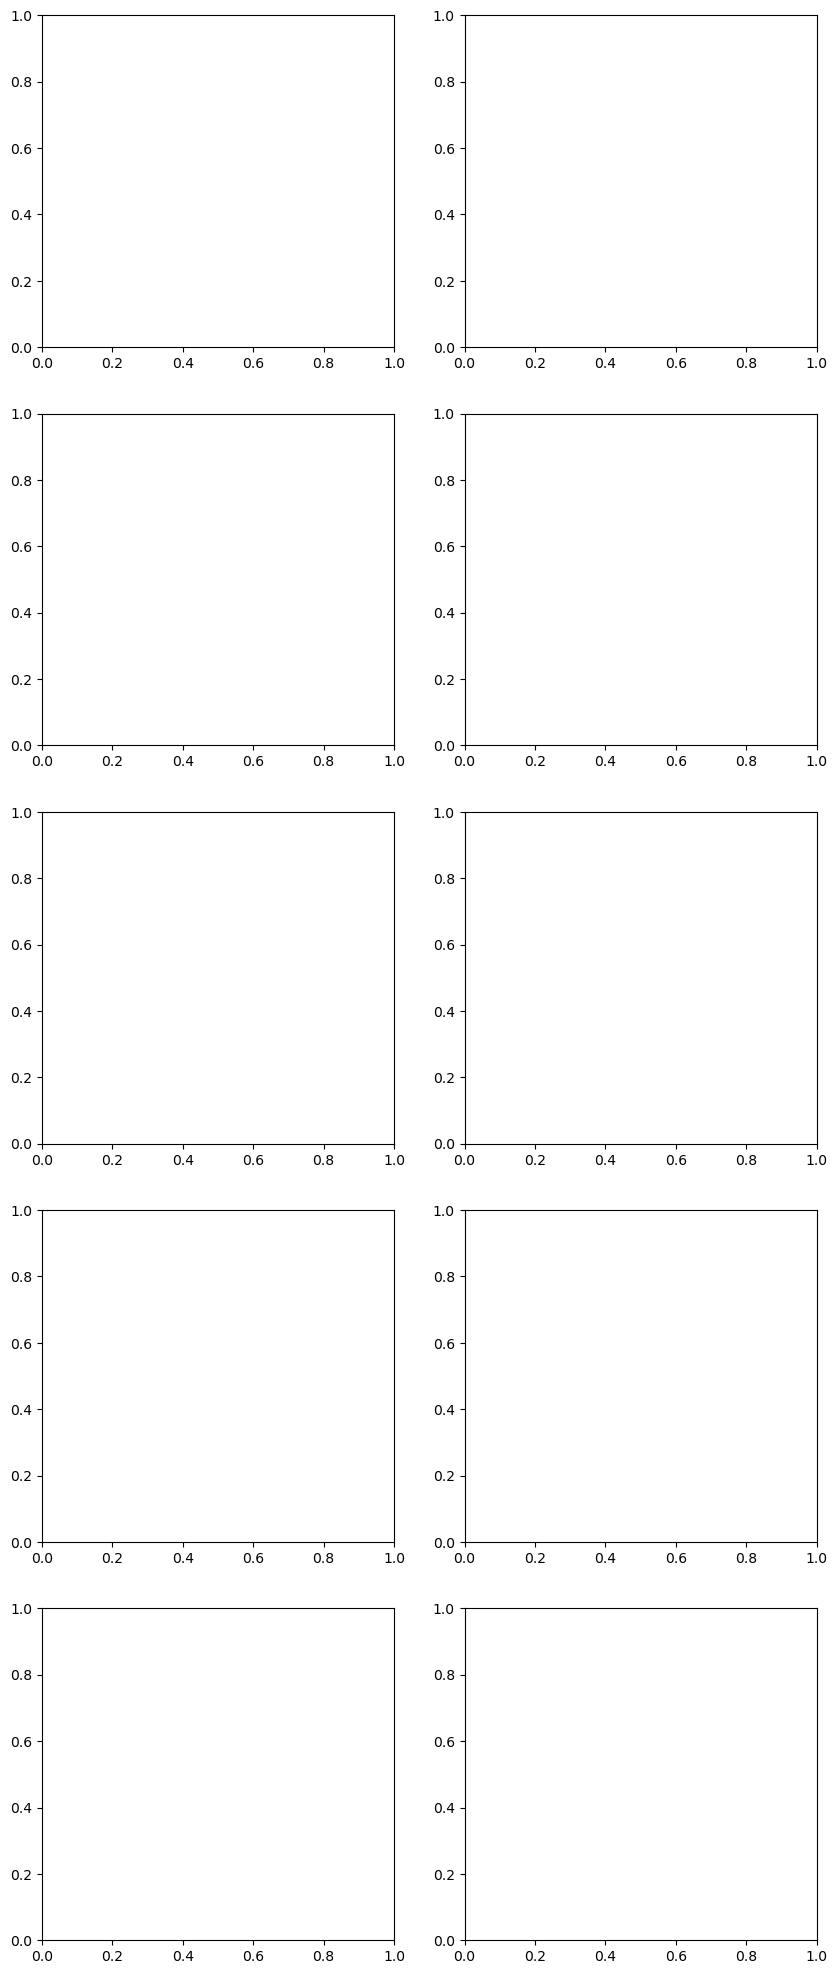

In [57]:
#n_layers_list: variation of the number of layers

n_tasks = 6 # number of tasks created. must be less than or equal to 2^len_taskcode.
len_taskcode = 8 # length of the code defining the task. This will go at the beginning of each entry
num_checks = 5  # Length of the associated integer list for each task. Must be less than len_message
len_message = 12  # Maximum integer value in the associated integer list
num_samples = 10000 # number of samples created in the dataset
samples_per_task = 1 # Kept at 1 for as long as I do not actually want to check the task performance
# Define hyperparameters
input_size = len_taskcode + len_message
output_size = 1
learning_rate = 0.005
batch_size = 32
num_epochs = 150
test_frac = 0.2
#num_layers = 4
num_layers_list = np.arange(1,25,5)
hidden_size = 32

def generate_random_binary_string(length):
    binary_string = ''.join(secrets.choice(['0', '1']) for _ in range(length))
    return binary_string

def generate_dict(n_tasks, len_taskcode, num_checks, len_message):
    unique_strings = set()
    tasks_dict = {}

    while len(unique_strings) < n_tasks:
        binary_string = generate_random_binary_string(len_taskcode)

        if binary_string not in unique_strings:
            unique_strings.add(binary_string)

            integer_list = [secrets.randbelow(len_message) for _ in range(num_checks)]
            tasks_dict[binary_string] = integer_list

    return tasks_dict

def generate_dataset(tasks_dict, num_samples):
  data = np.zeros((num_samples, len_taskcode + len_message))
  value = np.zeros(num_samples)
  for i in range(num_samples):
    rand_task = np.random.choice(list(tasks_dict))
    rand_checkbits = tasks_dict[rand_task]
    message = generate_random_binary_string(len_message)
    parity_bit = 0
    for j in rand_checkbits:
      parity_bit += int(message[j])
    parity = parity_bit % 2
    data[i] = np.concatenate((np.array(list(rand_task)), np.array(list(message))))
    value[i] = parity
  return [data, value]

# Define a NN class WITH BATCH NORMALISATION
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, output_size, num_layers, hidden_size):
        super(NeuralNetwork, self).__init__()

        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(input_size, hidden_size))  # Additional linear layer
        
        for _ in range(num_layers - 2):
            self.layers.append(nn.Linear(hidden_size, hidden_size))
            self.layers.append(nn.BatchNorm1d(hidden_size))  # Add BatchNorm1d layer
        
        self.layers.append(nn.Linear(hidden_size, output_size))
    
    def forward(self, x):
        for i, layer in enumerate(self.layers[:-1]):
            if i == 0:  # Apply ReLU activation only after the additional linear layer
                x = F.relu(layer(x))
            else:
                x = layer(x)
                if i % 2 == 0:
                    x = F.relu(x)  # Apply ReLU activation after each linear layer
        x = self.layers[-1](x)
        return x

# Define a custom dataset
class CustomDataset(Dataset):
    def __init__(self, dataframe):
        self.data = dataframe.iloc[:, :-1].values
        self.target = dataframe.iloc[:, -1].values
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        x = torch.from_numpy(self.data[idx]).float()
        y = torch.tensor(self.target[idx]).float()
        return x, y
    
#plt.close()
fig, axs = plt.subplots(len(num_layers_list), 2, figsize=(10, len(num_layers_list)*5))
for index, num_layers in enumerate(num_layers_list):
    
    tasks_dict = generate_dict(n_tasks, len_taskcode, num_checks, len_message)

    [data, value] = generate_dataset(tasks_dict, num_samples)

    # Create a dataframe for training
    df = pd.DataFrame(np.concatenate((data, value.reshape(-1, 1)), axis=1), columns=[f'feature_{i}' for i in range(len_taskcode + len_message)] + ['target'])

    # Split the data into training and test sets
    #train_df, test_df = train_test_split(df, test_size=test_frac, random_state=42)
    train_df, test_df = train_test_split(df, test_size=test_frac, random_state=42)

    # Create instances of the neural network
    model = NeuralNetwork(input_size, output_size, num_layers, hidden_size)

    # Define loss function and optimizer (same as before)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)

    # Create DataLoaders for the training and test data
    train_dataset = CustomDataset(train_df)
    test_dataset = CustomDataset(test_df)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    train_loss_list = np.empty(num_epochs)
    test_loss_list = np.empty(num_epochs)

    train_accuracy_list = np.empty(num_epochs)
    test_accuracy_list = np.empty(num_epochs)

    accuracy_array = np.zeros((n_tasks, num_epochs)) # such that each row is the accuracy for that specific task over all epochs

    # Train the model
    for epoch in tqdm(range(num_epochs)):
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        model.train()

        for inputs, labels in train_loader:
            # Forward pass
            outputs = model(inputs)

            # Compute loss
            loss = criterion(outputs, labels.unsqueeze(1))

            # Compute predictions
            predictions = (outputs >= 0.5).squeeze().long()

            # Compute accuracy
            train_correct += (predictions == labels).sum().item()
            train_total += labels.size(0)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)

        # Calculate average train loss
        train_loss = train_loss / len(train_dataset)
        # Calculate average train accuracy
        train_accuracy = train_correct / train_total

        # Evaluate the model on the test set
        model.eval()
        test_loss = 0.0
        test_correct = 0
        test_total = 0

        with torch.no_grad():
            for inputs, labels in test_loader:
                outputs = model(inputs)
                # Compute predictions
                predictions = (outputs >= 0.5).squeeze().long()

                # Compute accuracy
                test_correct += (predictions == labels).sum().item()
                test_total += labels.size(0)

                loss = criterion(outputs, labels.unsqueeze(1))
                test_loss += loss.item() * inputs.size(0)

            # Calculate average test loss
            test_loss = test_loss / len(test_dataset)

        # Calculate average test accuracy
        test_accuracy = test_correct / test_total

        # Update the loss lists
        train_loss_list[epoch] = train_loss
        test_loss_list[epoch] = test_loss

        train_accuracy_list[epoch] = train_accuracy
        test_accuracy_list[epoch] = test_accuracy


    # Create subplots with 1 row and 2 columns
    #fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    
    pytorch_total_params = sum(p.numel() for p in model.parameters())
    #print(f"Total model parameters = {pytorch_total_params}")

    # Plot the training and test losses on the first subplot
    axs[index,0].plot(range(1, num_epochs+1), train_loss_list, label='Train Loss')
    axs[index,0].plot(range(1, num_epochs+1), test_loss_list, label='Test Loss')
    axs[index,0].set_xlabel('Epoch')
    axs[index,0].set_ylabel('Loss')
    axs[index,0].legend()
    axs[index, 0].set_title(f'Loss for {num_layers} layers, {pytorch_total_params} parameters')  # Set title for the first subplot

    # Plot the training and test accuracies on the second subplot
    axs[index,1].plot(range(1, num_epochs+1), train_accuracy_list, label='Train Accuracy')
    axs[index,1].plot(range(1, num_epochs+1), test_accuracy_list, label='Test Accuracy')
    axs[index,1].set_xlabel('Epoch')
    axs[index,1].set_ylabel('Accuracy')
    axs[index,1].legend()
    axs[index,1].set_title(f'Accuracy for {num_layers} layers, {pytorch_total_params} parameters')

    # Adjust the spacing between subplots
#plt.tight_layout()
plt.suptitle('Model performance over optimisation steps', y=0.9) #y=0.9 seems about right for spacing here
    # Show the subplots
plt.show()

100%|██████████| 2/2 [00:00<00:00,  2.32it/s]


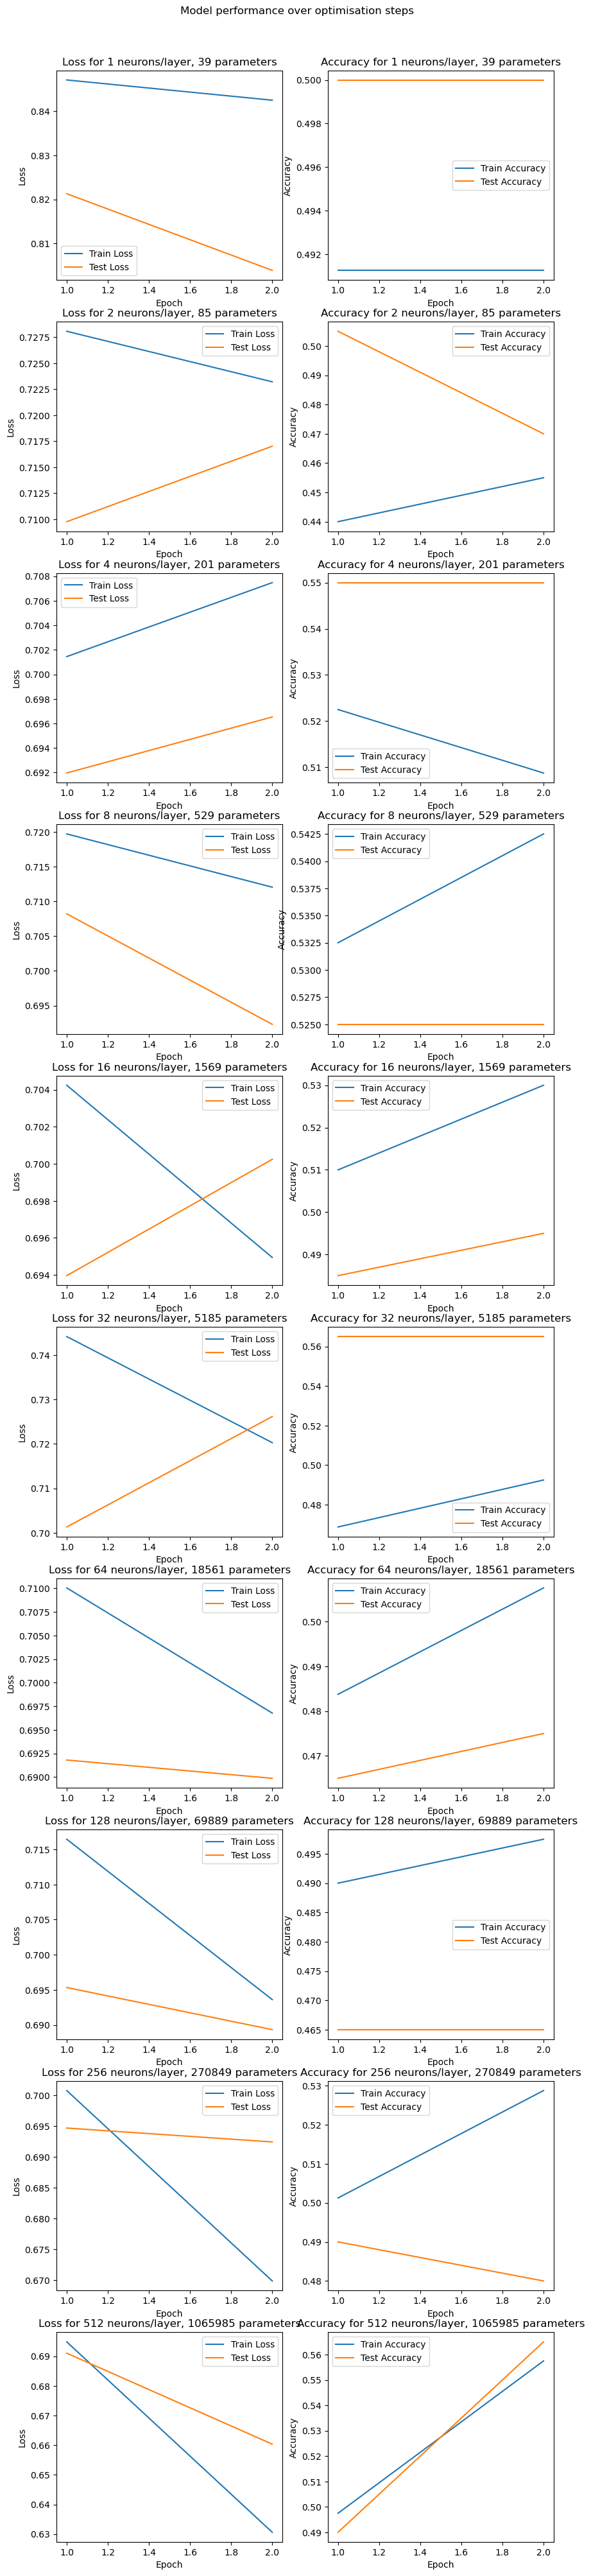

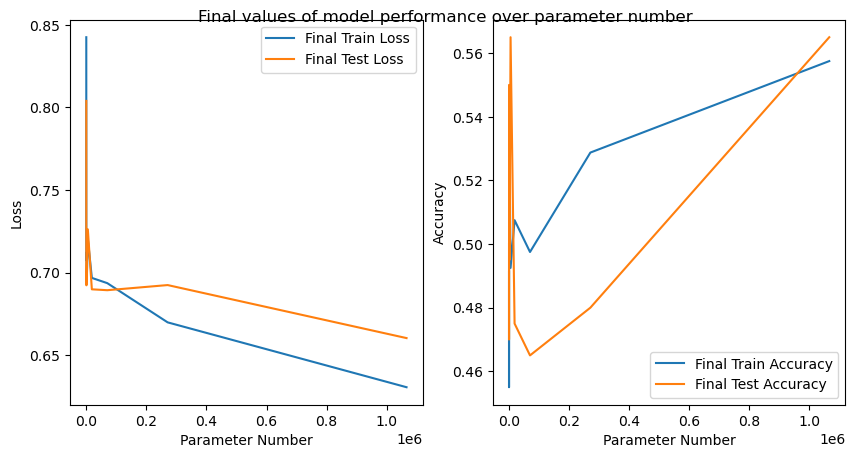

In [42]:
# hidden_size_list. Change the number of neurons in the hidden layer. Use n_tasks=6 and n_layers = 6 each time I think
# n_layers might be a bit too big, as I seemed to get pretty solid performance with n_layers = 4.

n_tasks = 6 # number of tasks created. must be less than or equal to 2^len_taskcode.
len_taskcode = 8 # length of the code defining the task. This will go at the beginning of each entry
num_checks = 3  # Length of the associated integer list for each task. Must be less than len_message
len_message = 12  # Maximum integer value in the associated integer list
num_samples = 1000 # number of samples created in the dataset
samples_per_task = 1 # Kept at 1 for as long as I do not actually want to check the task performance
# Define hyperparameters
input_size = len_taskcode + len_message
output_size = 1
learning_rate = 0.005
batch_size = 32
num_epochs = 100
test_frac = 0.2
num_layers = 6
#hidden_size_list = np.logspace(start=0, stop=9, num=10, endpoint=True, base=2, dtype=int) 
#[   1    2    4    8   16   32   64  128  256  512 1024]
hidden_size_list = np.arange(64, 1065, 100)

def generate_random_binary_string(length):
    binary_string = ''.join(secrets.choice(['0', '1']) for _ in range(length))
    return binary_string

def generate_dict(n_tasks, len_taskcode, num_checks, len_message):
    unique_strings = set()
    tasks_dict = {}

    while len(unique_strings) < n_tasks:
        binary_string = generate_random_binary_string(len_taskcode)

        if binary_string not in unique_strings:
            unique_strings.add(binary_string)

            integer_list = [secrets.randbelow(len_message) for _ in range(num_checks)]
            tasks_dict[binary_string] = integer_list

    return tasks_dict

def generate_dataset(tasks_dict, num_samples):
  data = np.zeros((num_samples, len_taskcode + len_message))
  value = np.zeros(num_samples)
  for i in range(num_samples):
    rand_task = np.random.choice(list(tasks_dict))
    rand_checkbits = tasks_dict[rand_task]
    message = generate_random_binary_string(len_message)
    parity_bit = 0
    for j in rand_checkbits:
      parity_bit += int(message[j])
    parity = parity_bit % 2
    data[i] = np.concatenate((np.array(list(rand_task)), np.array(list(message))))
    value[i] = parity
  return [data, value]

# Define a NN class WITH BATCH NORMALISATION
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, output_size, num_layers, hidden_size):
        super(NeuralNetwork, self).__init__()

        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(input_size, hidden_size))  # Additional linear layer
        
        for _ in range(num_layers - 2):
            self.layers.append(nn.Linear(hidden_size, hidden_size))
            self.layers.append(nn.BatchNorm1d(hidden_size))  # Add BatchNorm1d layer
        
        self.layers.append(nn.Linear(hidden_size, output_size))
    
    def forward(self, x):
        for i, layer in enumerate(self.layers[:-1]):
            if i == 0:  # Apply ReLU activation only after the additional linear layer
                x = F.relu(layer(x))
            else:
                x = layer(x)
                if i % 2 == 0:
                    x = F.relu(x)  # Apply ReLU activation after each linear layer
        x = self.layers[-1](x)
        return x

# Define a custom dataset
class CustomDataset(Dataset):
    def __init__(self, dataframe):
        self.data = dataframe.iloc[:, :-1].values
        self.target = dataframe.iloc[:, -1].values
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        x = torch.from_numpy(self.data[idx]).float()
        y = torch.tensor(self.target[idx]).float()
        return x, y
    
    
final_train_loss = np.empty(len(hidden_size_list))
final_test_loss = np.empty(len(hidden_size_list))
final_train_accuracy = np.empty(len(hidden_size_list))
final_test_accuracy = np.empty(len(hidden_size_list))
parameter_list = np.empty(len(hidden_size_list))
    
#plt.close()
fig, axs = plt.subplots(len(hidden_size_list), 2, figsize=(10, len(hidden_size_list)*5))
for index, hidden_size in enumerate(hidden_size_list):
    
    tasks_dict = generate_dict(n_tasks, len_taskcode, num_checks, len_message)

    [data, value] = generate_dataset(tasks_dict, num_samples)

    # Create a dataframe for training
    df = pd.DataFrame(np.concatenate((data, value.reshape(-1, 1)), axis=1), columns=[f'feature_{i}' for i in range(len_taskcode + len_message)] + ['target'])

    # Split the data into training and test sets
    #train_df, test_df = train_test_split(df, test_size=test_frac, random_state=42)
    train_df, test_df = train_test_split(df, test_size=test_frac, random_state=42)

    # Create instances of the neural network
    model = NeuralNetwork(input_size, output_size, num_layers, hidden_size)

    # Define loss function and optimizer (same as before)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)

    # Create DataLoaders for the training and test data
    train_dataset = CustomDataset(train_df)
    test_dataset = CustomDataset(test_df)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    train_loss_list = np.empty(num_epochs)
    test_loss_list = np.empty(num_epochs)

    train_accuracy_list = np.empty(num_epochs)
    test_accuracy_list = np.empty(num_epochs)

    accuracy_array = np.zeros((n_tasks, num_epochs)) # such that each row is the accuracy for that specific task over all epochs

    # Train the model
    for epoch in tqdm(range(num_epochs)):
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        model.train()

        for inputs, labels in train_loader:
            # Forward pass
            outputs = model(inputs)

            # Compute loss
            loss = criterion(outputs, labels.unsqueeze(1))

            # Compute predictions
            predictions = (outputs >= 0.5).squeeze().long()

            # Compute accuracy
            train_correct += (predictions == labels).sum().item()
            train_total += labels.size(0)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)

        # Calculate average train loss
        train_loss = train_loss / len(train_dataset)
        # Calculate average train accuracy
        train_accuracy = train_correct / train_total

        # Evaluate the model on the test set
        model.eval()
        test_loss = 0.0
        test_correct = 0
        test_total = 0

        with torch.no_grad():
            for inputs, labels in test_loader:
                outputs = model(inputs)
                # Compute predictions
                predictions = (outputs >= 0.5).squeeze().long()

                # Compute accuracy
                test_correct += (predictions == labels).sum().item()
                test_total += labels.size(0)

                loss = criterion(outputs, labels.unsqueeze(1))
                test_loss += loss.item() * inputs.size(0)

            # Calculate average test loss
            test_loss = test_loss / len(test_dataset)

        # Calculate average test accuracy
        test_accuracy = test_correct / test_total

        # Update the loss lists
        train_loss_list[epoch] = train_loss
        test_loss_list[epoch] = test_loss

        train_accuracy_list[epoch] = train_accuracy
        test_accuracy_list[epoch] = test_accuracy


    # Create subplots with 1 row and 2 columns
    #fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    
    pytorch_total_params = sum(p.numel() for p in model.parameters())
    #print(f"Total model parameters = {pytorch_total_params}")

    # Plot the training and test losses on the first subplot
    axs[index,0].plot(range(1, num_epochs+1), train_loss_list, label='Train Loss')
    axs[index,0].plot(range(1, num_epochs+1), test_loss_list, label='Test Loss')
    axs[index,0].set_xlabel('Epoch')
    axs[index,0].set_ylabel('Loss')
    axs[index,0].legend()
    axs[index, 0].set_title(f'Loss for {hidden_size} neurons/layer, {pytorch_total_params} parameters')  # Set title for the first subplot

    # Plot the training and test accuracies on the second subplot
    axs[index,1].plot(range(1, num_epochs+1), train_accuracy_list, label='Train Accuracy')
    axs[index,1].plot(range(1, num_epochs+1), test_accuracy_list, label='Test Accuracy')
    axs[index,1].set_xlabel('Epoch')
    axs[index,1].set_ylabel('Accuracy')
    axs[index,1].legend()
    axs[index,1].set_title(f'Accuracy for {hidden_size} neurons/layer, {pytorch_total_params} parameters')
    
    final_train_loss[index] = train_loss_list[-1]
    final_test_loss[index] = test_loss_list[-1]
    final_train_accuracy[index] = train_accuracy_list[-1]
    final_test_accuracy[index] = test_accuracy_list[-1]
    parameter_list[index] = pytorch_total_params

# Adjust the spacing between subplots
#plt.tight_layout()
plt.suptitle('Model performance over optimisation steps', y=0.9) #y=0.9 seems about right for spacing here
# Show the subplots
plt.show()

plt.close()

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].plot(parameter_list, final_train_loss, label='Final Train Loss')
axs[0].plot(parameter_list, final_test_loss, label='Final Test Loss')
axs[0].set_xlabel('Parameter Number')
axs[0].set_ylabel('Loss')
axs[0].legend()
# title

axs[1].plot(parameter_list, final_train_accuracy, label='Final Train Accuracy')
axs[1].plot(parameter_list, final_test_accuracy, label='Final Test Accuracy')
axs[1].set_xlabel('Parameter Number')
axs[1].set_ylabel('Accuracy')
axs[1].legend()

plt.suptitle('Final values of model performance over parameter number', y=0.9)
plt.show()

Working


100%|██████████| 10/10 [00:00<00:00, 57.90it/s]


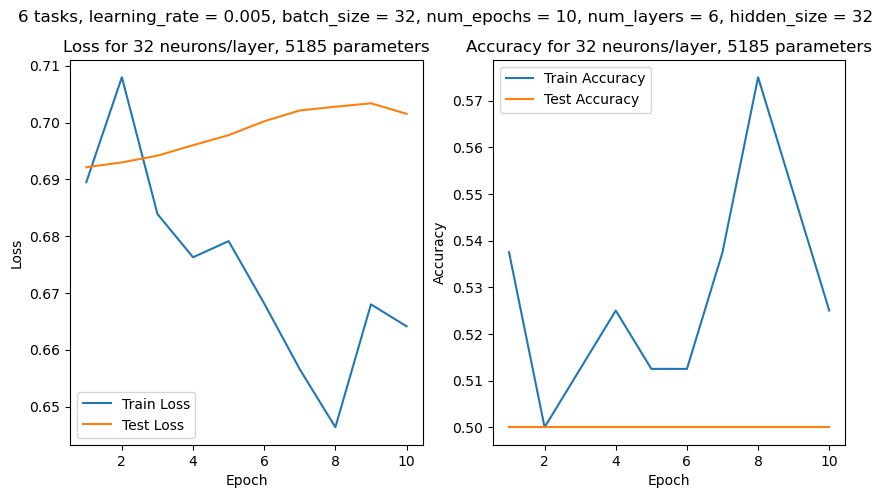

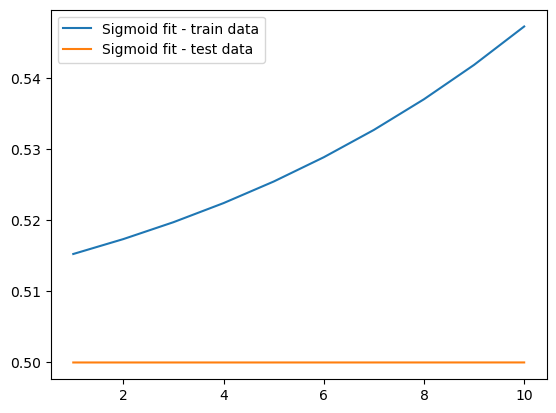

100%|██████████| 10/10 [00:01<00:00,  9.23it/s]


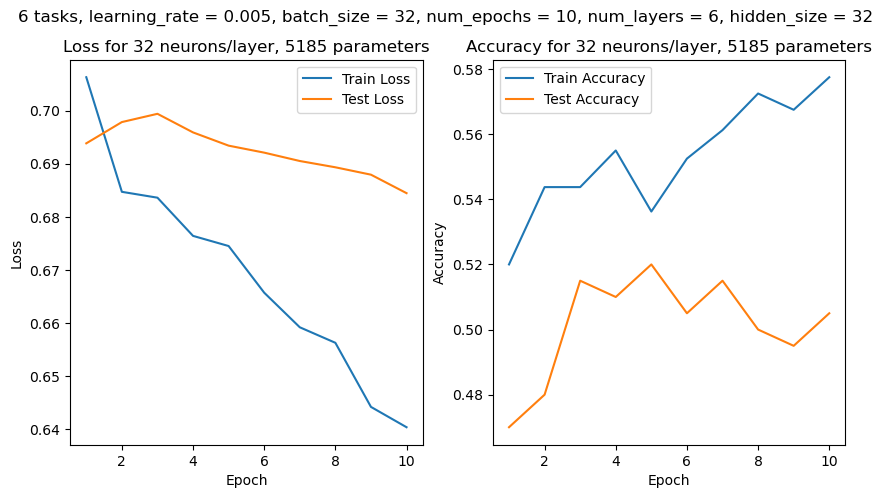

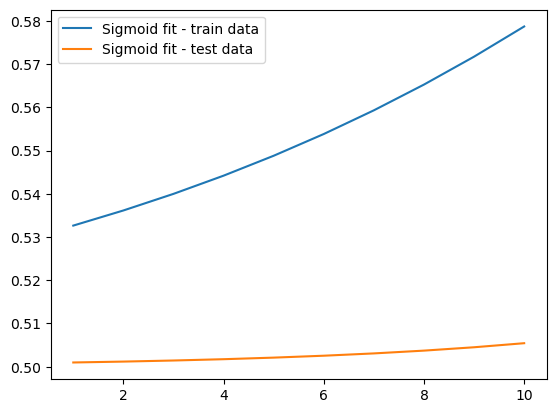

100%|██████████| 10/10 [00:11<00:00,  1.19s/it]


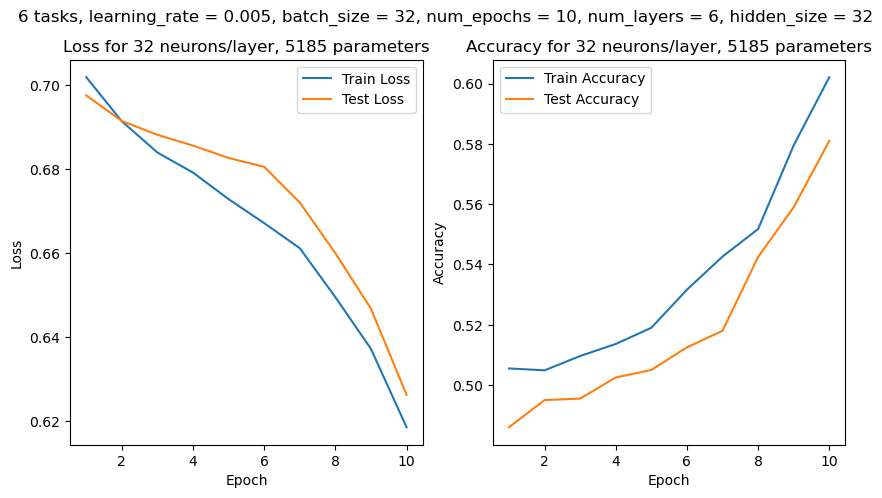

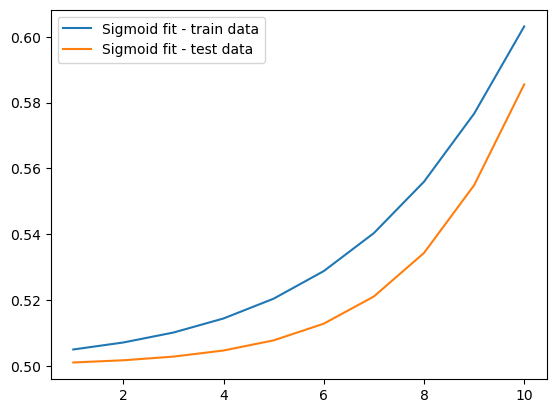

[[26.95749728  0.13320619  0.5       ]
 [25.34782092  0.1093099   0.52      ]
 [13.72156038  0.36202859  0.504875  ]]
[[39.89742612  0.38424477  0.5       ]
 [33.57462165  0.19130394  0.47      ]
 [13.06172287  0.51539417  0.486     ]]


In [69]:
# General hyperparameter search cell. All for finite data.
# Will iterate over a broad range of parameters. 
# If you do not want to iterate over something, put it as a list
print('Working')

#n_tasks_list = np.arange(1, 10, 1) # number of tasks created. must be less than or equal to 2^len_taskcode.
n_tasks_list = [6]
len_taskcode = 8 # length of the code defining the task. This will go at the beginning of each entry
num_checks = 3  # Length of the associated integer list for each task. Must be less than len_message
len_message = 12  # Maximum integer value in the associated integer list
num_samples_list = np.logspace(start=2, stop=4, num=3, base=10, dtype=int) # number of samples created in the dataset
samples_per_task = 1 # Kept at 1 for as long as I do not actually want to check the task performance
# Define hyperparameters
input_size = len_taskcode + len_message
output_size = 1
learning_rate_list = [0.005]
batch_size_list = [32]
num_epochs_list = [10]
test_frac = 0.2 #no iteration
num_layers_list = [6]
#hidden_size_list = np.logspace(start=0, stop=5, num=6, base=2, dtype=int)
hidden_size_list = [32]
#[   1    2    4    8   16   32   64  128  256  512 1024]


def generate_random_binary_string(length):
    binary_string = ''.join(secrets.choice(['0', '1']) for _ in range(length))
    return binary_string

def generate_dict(n_tasks, len_taskcode, num_checks, len_message):
    unique_strings = set()
    tasks_dict = {}

    while len(unique_strings) < n_tasks:
        binary_string = generate_random_binary_string(len_taskcode)

        if binary_string not in unique_strings:
            unique_strings.add(binary_string)

            integer_list = [secrets.randbelow(len_message) for _ in range(num_checks)]
            tasks_dict[binary_string] = integer_list

    return tasks_dict

def generate_dataset(tasks_dict, num_samples):
  data = np.zeros((num_samples, len_taskcode + len_message))
  value = np.zeros(num_samples)
  for i in range(num_samples):
    rand_task = np.random.choice(list(tasks_dict))
    rand_checkbits = tasks_dict[rand_task]
    message = generate_random_binary_string(len_message)
    parity_bit = 0
    for j in rand_checkbits:
      parity_bit += int(message[j])
    parity = parity_bit % 2
    data[i] = np.concatenate((np.array(list(rand_task)), np.array(list(message))))
    value[i] = parity
  return [data, value]

# Define a NN class WITH BATCH NORMALISATION
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, output_size, num_layers, hidden_size):
        super(NeuralNetwork, self).__init__()

        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(input_size, hidden_size))  # Additional linear layer
        
        for _ in range(num_layers - 2):
            self.layers.append(nn.Linear(hidden_size, hidden_size))
            self.layers.append(nn.BatchNorm1d(hidden_size))  # Add BatchNorm1d layer
        
        self.layers.append(nn.Linear(hidden_size, output_size))
    
    def forward(self, x):
        for i, layer in enumerate(self.layers[:-1]):
            if i == 0:  # Apply ReLU activation only after the additional linear layer
                x = F.relu(layer(x))
            else:
                x = layer(x)
                if i % 2 == 0:
                    x = F.relu(x)  # Apply ReLU activation after each linear layer
        x = self.layers[-1](x)
        return x

# Define a custom dataset
class CustomDataset(Dataset):
    def __init__(self, dataframe):
        self.data = dataframe.iloc[:, :-1].values
        self.target = dataframe.iloc[:, -1].values
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        x = torch.from_numpy(self.data[idx]).float()
        y = torch.tensor(self.target[idx]).float()
        return x, y
    
# For later curve fitting
def sigmoid(x, L ,x0, k, b):
    # L is overll scale, x0 is x translation, b is y translation, k is width
    y = L / (1 + np.exp(-k*(x-x0))) + b
    return (y)

# For later curve fitting. Assumes that the accuracy goes between 0.5 and 1
def constrained_sigmoid(x, x0, k, b):
    y = 0.5 / (1 + np.exp(-k*(x-x0))) + 0.5
    return y
    
    
final_train_loss = np.empty(len(hidden_size_list))
final_test_loss = np.empty(len(hidden_size_list))
final_train_accuracy = np.empty(len(hidden_size_list))
final_test_accuracy = np.empty(len(hidden_size_list))
parameter_list = np.empty(len(hidden_size_list))

# For sigmoid fits. At the moment arranged for constrained_sigmoid
train_sig_params = np.zeros((len(num_samples_list), 3))
test_sig_params = np.zeros((len(num_samples_list), 3))

#plt.close()
#fig, axs = plt.subplots(len(hidden_size_list), 2, figsize=(10, len(hidden_size_list)*5))
combinations = itertools.product(n_tasks_list, num_samples_list, learning_rate_list, batch_size_list, 
                                 num_epochs_list, num_layers_list, hidden_size_list)
i = 0 #iteration counter
for combination in combinations:
    n_tasks, num_samples, learning_rate, batch_size, num_epochs, num_layers, hidden_size = combination

    tasks_dict = generate_dict(n_tasks, len_taskcode, num_checks, len_message)

    [data, value] = generate_dataset(tasks_dict, num_samples)

    # Create a dataframe for training
    df = pd.DataFrame(np.concatenate((data, value.reshape(-1, 1)), axis=1), columns=[f'feature_{i}' for i in range(len_taskcode + len_message)] + ['target'])

    # Split the data into training and test sets
    #train_df, test_df = train_test_split(df, test_size=test_frac, random_state=42)
    train_df, test_df = train_test_split(df, test_size=test_frac, random_state=42)

    # Create instances of the neural network
    model = NeuralNetwork(input_size, output_size, num_layers, hidden_size)

    # Define loss function and optimizer (same as before)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)

    # Create DataLoaders for the training and test data
    train_dataset = CustomDataset(train_df)
    test_dataset = CustomDataset(test_df)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    train_loss_list = np.empty(num_epochs)
    test_loss_list = np.empty(num_epochs)

    train_accuracy_list = np.empty(num_epochs)
    test_accuracy_list = np.empty(num_epochs)

    accuracy_array = np.zeros((n_tasks, num_epochs)) # such that each row is the accuracy for that specific task over all epochs

    # Train the model
    for epoch in tqdm(range(num_epochs)):
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        model.train()

        for inputs, labels in train_loader:
            # Forward pass
            outputs = model(inputs)

            # Compute loss
            loss = criterion(outputs, labels.unsqueeze(1))

            # Compute predictions
            predictions = (outputs >= 0.5).squeeze().long()

            # Compute accuracy
            train_correct += (predictions == labels).sum().item()
            train_total += labels.size(0)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)

        # Calculate average train loss
        train_loss = train_loss / len(train_dataset)
        # Calculate average train accuracy
        train_accuracy = train_correct / train_total

        # Evaluate the model on the test set
        model.eval()
        test_loss = 0.0
        test_correct = 0
        test_total = 0

        with torch.no_grad():
            for inputs, labels in test_loader:
                outputs = model(inputs)
                # Compute predictions
                predictions = (outputs >= 0.5).squeeze().long()

                # Compute accuracy
                test_correct += (predictions == labels).sum().item()
                test_total += labels.size(0)

                loss = criterion(outputs, labels.unsqueeze(1))
                test_loss += loss.item() * inputs.size(0)

            # Calculate average test loss
            test_loss = test_loss / len(test_dataset)

        # Calculate average test accuracy
        test_accuracy = test_correct / test_total

        # Update the loss lists
        train_loss_list[epoch] = train_loss
        test_loss_list[epoch] = test_loss

        train_accuracy_list[epoch] = train_accuracy
        test_accuracy_list[epoch] = test_accuracy


    # Create subplots with 1 row and 2 columns
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    
    pytorch_total_params = sum(p.numel() for p in model.parameters())
    #print(f"Total model parameters = {pytorch_total_params}")

    # Plot the training and test losses on the first subplot
    axs[0].plot(range(1, num_epochs+1), train_loss_list, label='Train Loss')
    axs[0].plot(range(1, num_epochs+1), test_loss_list, label='Test Loss')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Loss')
    axs[0].legend()
    axs[0].set_title(f'Loss for {hidden_size} neurons/layer, {pytorch_total_params} parameters')  # Set title for the first subplot

    # Plot the training and test accuracies on the second subplot
    axs[1].plot(range(1, num_epochs+1), train_accuracy_list, label='Train Accuracy')
    axs[1].plot(range(1, num_epochs+1), test_accuracy_list, label='Test Accuracy')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend()
    axs[1].set_title(f'Accuracy for {hidden_size} neurons/layer, {pytorch_total_params} parameters')
    
    plt.suptitle(f'{n_tasks} tasks, learning_rate = {learning_rate}, batch_size = {batch_size}, num_epochs = {num_epochs}, num_layers = {num_layers}, hidden_size = {hidden_size}', y=0.98)
    plt.show()
    
    # Used when general sigmoid function is being fit
    '''
    # Calculate different sigmoid fits.. Just accuracy for now
    epoch_list = range(1, num_epochs+1)
    p0_train = [max(train_accuracy_list), np.median(epoch_list) , 1 , min(train_accuracy_list)] # this is an mandatory initial guess
    popt_train, pcov_train = curve_fit(sigmoid, epoch_list, train_accuracy_list, p0_train, method='dogbox')
    p0_test = [max(test_accuracy_list), np.median(epoch_list) , 1 , min(test_accuracy_list)]
    popt_test, pcov_test = curve_fit(sigmoid, epoch_list, test_accuracy_list, p0_test, method='dogbox')
    
    train_accuracy_fit = sigmoid(epoch_list, popt_train[0], popt_train[1], popt_train[2], popt_train[3])
    test_accuracy_fit = sigmoid(epoch_list, popt_test[0], popt_test[1], popt_test[2], popt_test[3])
    '''

    # Used when constrained sigmoid function is being fit
    epoch_list = range(1, num_epochs+1)
    try:
        p0_train = [np.median(epoch_list) , 1 , min(train_accuracy_list)] # this is an mandatory initial guess
        popt_train, pcov_train = curve_fit(constrained_sigmoid, epoch_list, train_accuracy_list, p0_train, method='dogbox')
        p0_test = [np.median(epoch_list) , 1 , min(test_accuracy_list)]
        popt_test, pcov_test = curve_fit(constrained_sigmoid, epoch_list, test_accuracy_list, p0_test, method='dogbox')
    
        train_accuracy_fit = constrained_sigmoid(epoch_list, popt_train[0], popt_train[1], popt_train[2])
        test_accuracy_fit = constrained_sigmoid(epoch_list, popt_test[0], popt_test[1], popt_test[2])

        plt.plot(epoch_list, train_accuracy_fit, label='Sigmoid fit - train data')
        plt.plot(epoch_list, test_accuracy_fit, label='Sigmoid fit - test data')
        plt.legend()
        plt.show()
        
        train_sig_params[i] = popt_train
        test_sig_params[i] = popt_test
        
    except RuntimeError:
        print('Failed to find optimal solution')
    i += 1
    
print(train_sig_params)
print(test_sig_params)